<center><h1>INNOVATION SQUAD : Mini Challenge</h1></center>
<center><strong>Author : Salma JERIDI</strong></center>

### Objective : 
Forecast the German day-ahead prices, Knowing that, only the prices from previous days are available when the forecast is computed because of publication lags. Meaning that, to forecast the prices of day $d$ we have only access to prices from days $d-x$ where $x\geq 2$

**Data :** Contains all hourly market prices from January 01, 2016 until May 31, 2018. 

**Evaluation Metrics :**  We will use the Root Mean Square Error (RMSE) to evaluate the forecast as well as Mean Absolute Error (MAE) and Mean Average Percentage Error (MAPE). 

### Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import  StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Add
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from xgboost import XGBRegressor
%matplotlib inline
sns.set()

Using TensorFlow backend.


In [0]:
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error ,mean_squared_error

In [0]:
import warnings
warnings.filterwarnings('ignore')

### Load and process data : 

In [0]:
def Load_data(path): 
    
    dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y %H:%M')
    df = pd.read_csv(path, parse_dates=['Date'], date_parser=dateparse,index_col=['Date'])
    df.drop(['Unnamed: 0','label'], axis=1,inplace=True) 
    print("Data loaded...")
    print("Data shape :", df.shape)
    print('Number of observations : ',df.shape[0])
    print('Observations are historical hourly Day-Ahead market prices in German starting from ',
          df.index[0].date()," to ",df.index[-1].date())
    return df

In [7]:
path="challenge_data_science_engie_2019.csv"
Dataframe = Load_data(path)

Data loaded...
Data shape : (21165, 1)
Number of observations :  21165
Observations are historical hourly Day-Ahead market prices in German starting from  2016-01-01  to  2018-05-31


In [8]:
## Data describtion : Major statistical characteristics of the price data 
Dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
Value,21165.0,32.071798,15.519885,-130.09,24.43,31.92,39.12,163.52


**The average price is 32.07 €/MWh.**<br>
**Half of the observations are between 24.43 €/MWh and 39.12 €/MWh**


In [9]:
## Check if there are some missing values or  redundant indexes or missing ones 
print(' Missing values: ',Dataframe['Value'].isna().sum())
print(' Missing indexes : ',np.where(Dataframe.index.to_series().diff()>pd.Timedelta('01:00:00')))
print(' Redundant indexes :',np.where(Dataframe.index.to_series().diff()==pd.Timedelta('00:00:00')))
## records are missing in 27/03/2016,26/03/2017,25/03/2018 02:00:00

 Missing values:  0
 Missing indexes :  (array([ 2066, 10801, 19536]),)
 Redundant indexes : (array([], dtype=int64),)


**3 Indexes are missing in the data dur to Daylight saving time :**
- 2016-03-27 02:00:00 
- 2017-03-26 02:00:00
- 2018-03-25 02:00:00 <br>
We must fill these missing indexes by inserting new rows where no value previously existed and then impute missing values by interpolation, Forward/Backward filling , ... 

In [10]:
## fill missing indexes : 
idx = pd.date_range(min(Dataframe.index), max(Dataframe.index),freq='H')
Dataframe= Dataframe.reindex(idx)
## interpolate the 3 missing values 
Dataframe['Value'].interpolate(method='linear', inplace=True)
print('Missing values: ',Dataframe['Value'].isna().sum())


Missing values:  0


### Exploratory data analysis : 

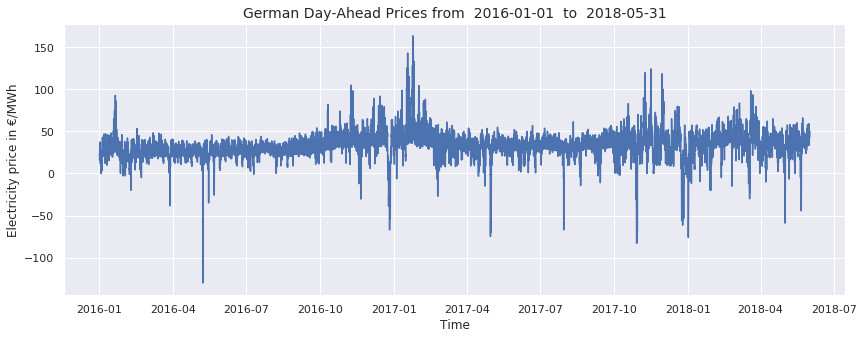

In [10]:
## plot signal
plt.figure(figsize=(14,5))
plt.plot(Dataframe)
plt.ylabel('Electricity price in €/MWh')
plt.xlabel('Time')
plt.title('German Day-Ahead Prices from  2016-01-01  to  2018-05-31', fontsize=14)
plt.show()

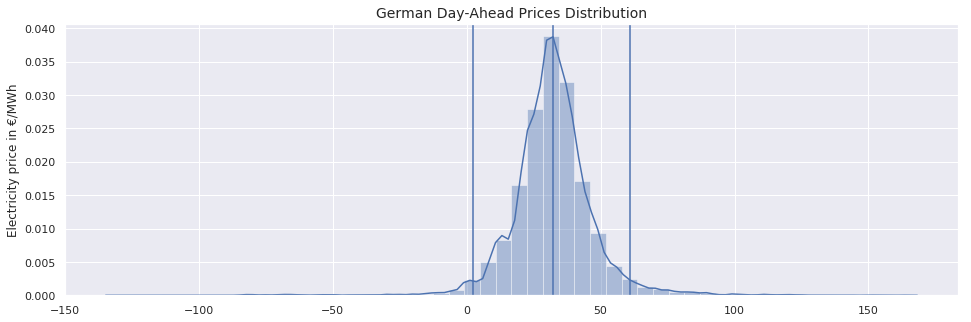

In [11]:
# Dataframe.plot(kind='kde',figsize=(16,5))
plt.figure(figsize=(16,5))
sns.distplot(Dataframe)
plt.ylabel('Electricity price in €/MWh')
plt.title('German Day-Ahead Prices Distribution', fontsize=14)
mean =Dataframe.Value.mean()
q75 = Dataframe.Value.quantile(.75)
q25 = Dataframe.Value.quantile(.25)
IQR = q75 - q25
xcoords = [mean,  q25 - 1.5 * IQR, q75  + 1.5 * IQR]
for xc in xcoords:
    plt.axvline(x=xc)
plt.show()

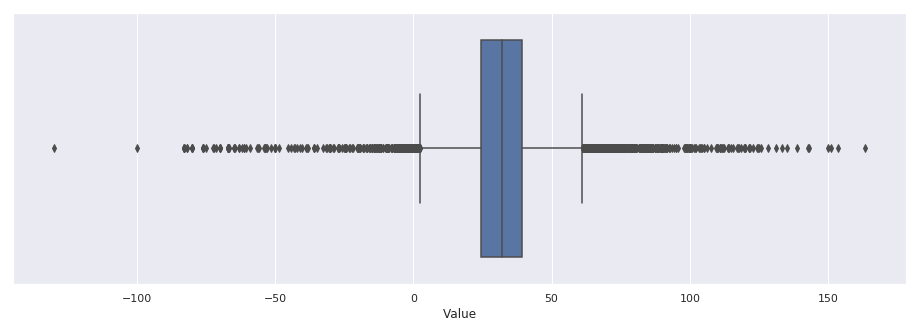

In [0]:
## Boxplot
fig, ax = plt.subplots(figsize=(16,5))
sns.boxplot( Dataframe.Value, ax=ax)

**Shall we  consider these extreme price peaks and lows as outliers and remove them ? These outliers may be real values that should be further investigated. Simply dropping or removing them because they won't fit in our model nicely may not be a good approach.However keeping them could  screw up the scaling process (especially minmax).**

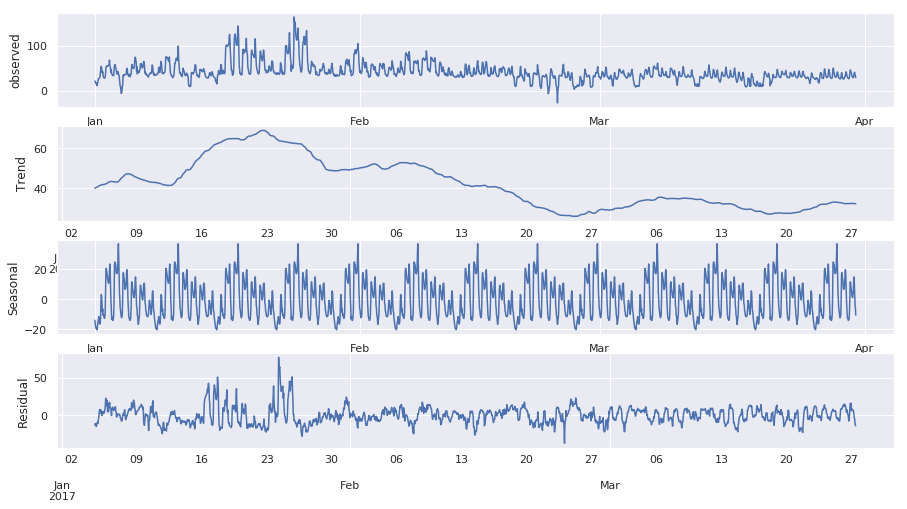

In [0]:
# Decompose the time series into trends, seasonal, residual 
# try different frequencies to detect seasonalities 
# visualize over a short period to have clear graphs, eg :'2017-01-01':'2017-03-30'
##freq = (24h*60min/xmin)* n days 
def decompose_time_series(series ,freq):
    """
    Decompose a time series and plot it in the console
    Arguments: 
        series: series. Time series that we want to decompose
    Outputs: 
        Decomposition plot in the console
    """
    res = seasonal_decompose(series, model='additive',freq=freq)


    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))
    res.observed.plot(ax=ax1  )
    res.trend.plot(ax=ax2)
    res.seasonal.plot(ax=ax3)
    res.resid.plot(ax=ax4)
    ax1.set( ylabel='observed')
    ax2.set( ylabel='Trend')
    ax3.set( ylabel='Seasonal')
    ax4.set( ylabel='Residual')
                    
    plt.show()

decompose_time_series(Dataframe.loc['2017-01-01':'2017-03-30','Value'], freq =24*7)

**Multiple seasonalities could be detected ( daily, weekly, monthly periodicity), by changing frequency and observing over a short period to have clear graphs**

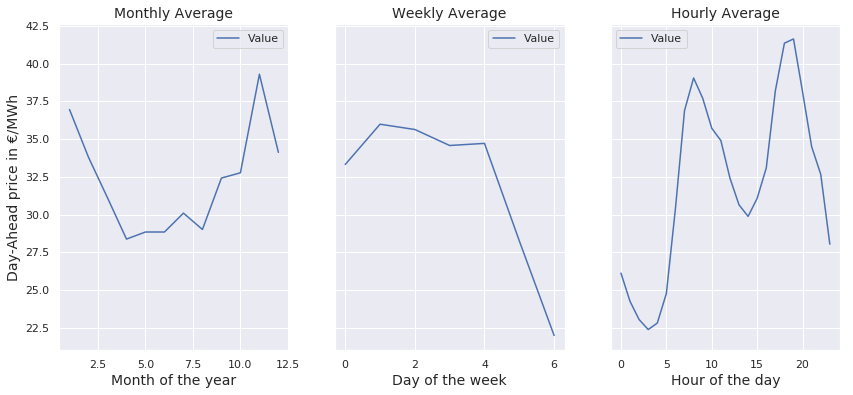

In [0]:
def average_plots(data):
    
    """Plot monthly, daily and hourly averages of input data."""
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
    plt.grid()
    data.groupby(data.index.month).mean().plot(ax=ax1)
    ax1.set_title('Monthly Average', fontsize=14)
    ax1.set_ylabel('Day-Ahead price in €/MWh', fontsize=14)
    ax1.set_xlabel('Month of the year', fontsize=14)
    data.groupby(data.index.dayofweek).mean().plot(ax=ax2)
    ax2.set_title('Weekly Average', fontsize=14)
    ax2.set_xlabel('Day of the week', fontsize=14)
    data.groupby(data.index.hour).mean().plot(ax=ax3)
    ax3.set_title('Hourly Average', fontsize=14)
    ax3.set_xlabel('Hour of the day', fontsize=14)

    
average_plots(Dataframe)

- **Yearly patterns : As we can see, higher prices are detected during november, december and january, while lower prices are during summer.**<br>
- **Weekly patterns :  Electricity prices fall considerably during the weekend.**<br>
- **Daily patterns : Peaks in the morning and evening periods.**


#### Outliers detection : 

In [21]:
## in case we are interested in replacing outliers by threshold
## tolerance =3 to detect extreme outliers
def IQR_outliers_detection(data, column, tolerance): 
    tol = tolerance
    data_prep = data.copy(deep=True)
    
    # calculate quantiles and inter-quantile range of the data
    q75 = data_prep[column].quantile(.75)
    q25 = data_prep[column].quantile(.25)
    IQR = q75 - q25

    # values larger (smaller) than q75 (q25) plus 'tol' times IQR get replaced by that value
    data_prep[column] = data_prep[column].apply(lambda x: q75 + tol * IQR if (x > q75 + tol * IQR) else x)
    data_prep[column] = data_prep[column].apply(lambda x: q25 - tol * IQR if (x < q25 - tol * IQR) else x)
    
    return data_prep

New_df = IQR_outliers_detection(Dataframe, 'Value', 3)
New_df.shape

(21168, 1)

#### Normalize data 

In [0]:
## Data scaling : 
scaler = MinMaxScaler()
New_df['Value'] = scaler.fit_transform(New_df)

In [0]:
# Dataframe['Value'].asfreq('M').plot()

## Modelling : 

**We will train the model on historical timeseries data. 
In order to predict the next 24 hours of a single day, we need historical price values for the last $n$ hours prior to the day when we are computing the forecast. 
The figure below shows  how the blue part of the data will serve as input for predicting the green part without considering the 24 hours just before.**

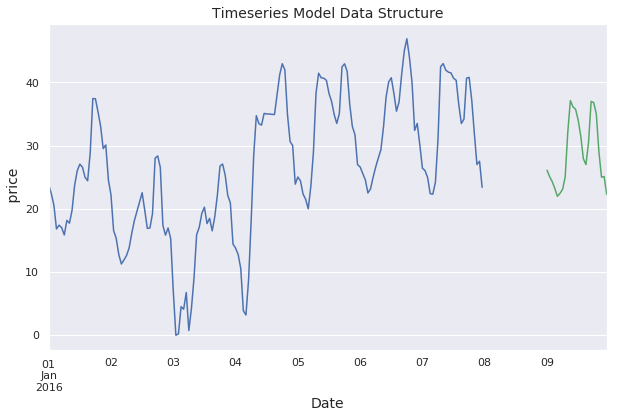

In [13]:
feature_data = Dataframe.loc['2016-01-01':'2016-01-07', 'Value']
feature_data.columns = ['input data']
label_data = Dataframe.loc['2016-01-09', 'Value']
label_data.columns = ['data to predict']
f, ax = plt.subplots(figsize=(10, 6))
feature_data.plot(ax=ax)
label_data.plot(ax=ax, color='g')
ax.set_ylabel(' price', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Timeseries Model Data Structure', fontsize=14);

### Using statistical Models for time series forecast : 


In [0]:
## useful functions
def get_train_test_data(df, start, end, train_ratio):
    data = df[start:end]
    train_size = int(train_ratio*len(data))
    train_data = data[:train_size].values
    test_data = data[train_size:].values
    
    return train_data, test_data

def train_predict_sarimax(train , order , seasonal_order):
    
    
    model = SARIMAX(train,order= order, seasonal_order= seasonal_order , )
    model = model.fit()
    preds_value= model.forecast(48) 
    
    return model, preds_value

def ar_ma (train, nlags= None):
    """ get automatically the ar and ma parameters for arima"""
    if nlags is None : 
        nlags=168
        
    t_acf , t_cnt = acf(train,  nlags=nlags, alpha=0.05)
    t_pacf , t_pcnt = pacf(train,  nlags=nlags, alpha=0.05)
    ma = [True  if  (x > 0.1 or x< -0.1 )else False for i,x in enumerate(t_pacf)]
    ar = [True  if (x > 0.1 or x< -0.1 )  else False for i,x in enumerate(t_acf) ]
    try: 
        r_ma = ma.index(False)
    except: 
        r_ma = len(ma)
    try: 
        r_ar = ar.index(False)
    except: 
        r_ar = len(ar)
    return r_ma , r_ar


def plot_preds(train,test,preds):
    """Function to plot predicions"""
    n= len(train)
    plt.figure(figsize=(16,8))
    plt.plot(np.arange(n), train, label='real past values')
    plt.plot(np.arange(n,n+len(test)),test,label='real future values')
    plt.plot(np.arange(n,n+len(test)),preds, label='forecasted future values')
    plt.legend()
    plt.title('Predictions vs. Actual for first day in test set')
    plt.show()
    
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    

## ARIMA (p,d,q) : 
The  parametres for the ARIMA model are  (p, d, q) : 
- p (autoregressive)
- d (differncing)
- q (moving average)

Because ARIMA is computationally intensive we will test the model only wit the first day of the test set and see the results. 

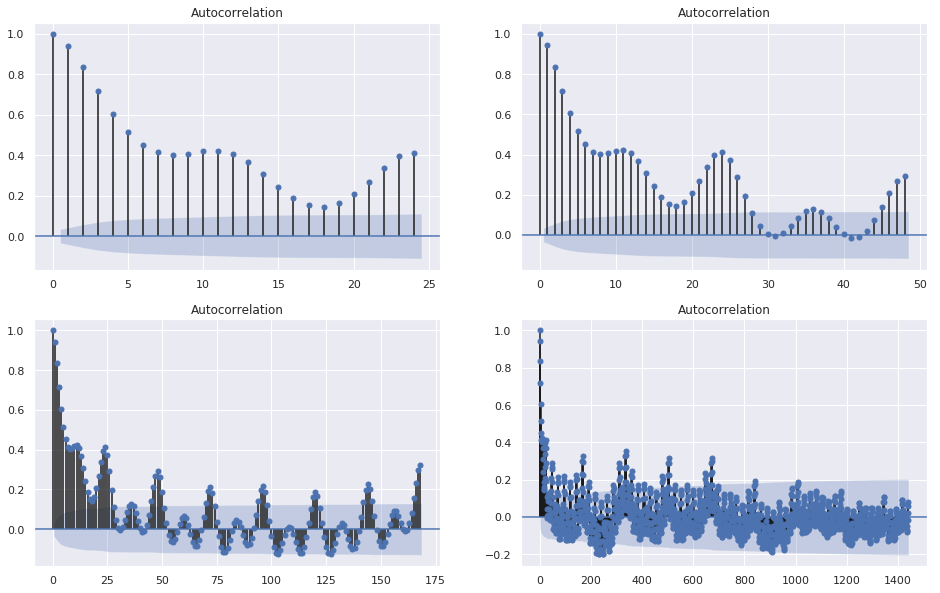

In [14]:
## Investigate autocorrelation with lags
train , test = get_train_test_data(Dataframe, '2018-01', '2018-05', 0.9)
#plot the ACF 
fig, axs = plt.subplots(2,2, figsize=(16,10))

lags = [24, 24*2, 24*7,24*60]

for lag, ax in zip(lags, axs.flatten()):
    plot_acf(train, lags=lag, ax=ax)
plt.show()

**The autocorrelation plot shows significant positive corelations in the first 30 lags. 
The cyclic pattern of the autoregressive features is apparent in the plots. In the ARIMA model the assumption is that beyond the chosen lag point (p), there is no correlation. Observing the bottom right plot we see this point occurs around approximately 700 lags (approximately 1 month).But, until this point, correclation values aren't really important.
We will focus on lag points 24 (previous day), 48 (previous two days), 168 (previous week).**

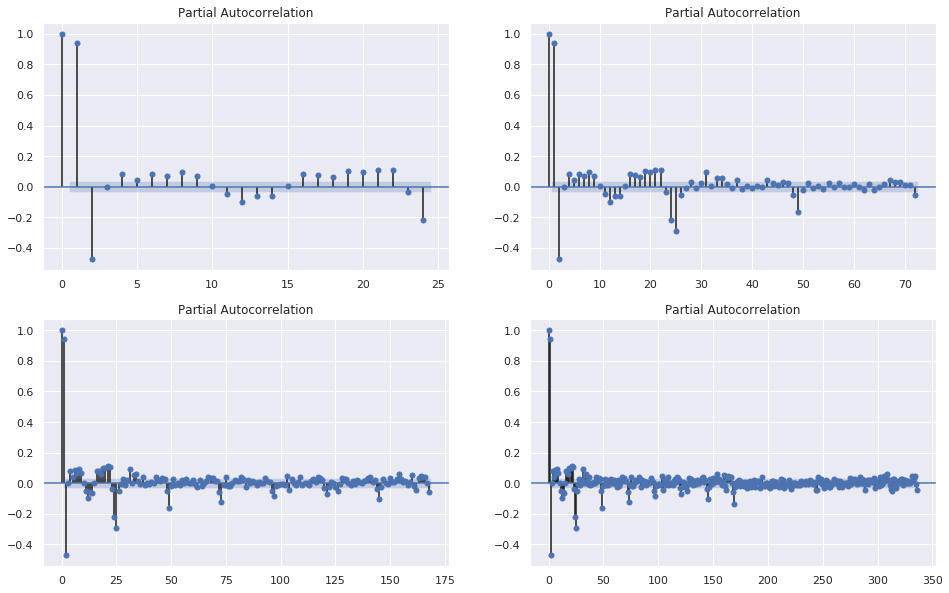

In [16]:
## Investigate partial autocorrelation 
fig, axs = plt.subplots(2,2, figsize=(16,10))

lags = [24, 24*3, 24*7, 24*14]

for lag, ax in zip(lags, axs.flatten()):
    plot_pacf(train, lags=lag, ax=ax)
plt.show()


**The partial autocorrelation plot shows that beyond 24 lags there is no signficant partial autocorrelation. Considering this we will investigate lags 2, 3, 12, and 24 for the moving average values.**

**The above plots help us choosing the right AR  and MA values to investigate, but we can find them automatically with the ar_ma function**

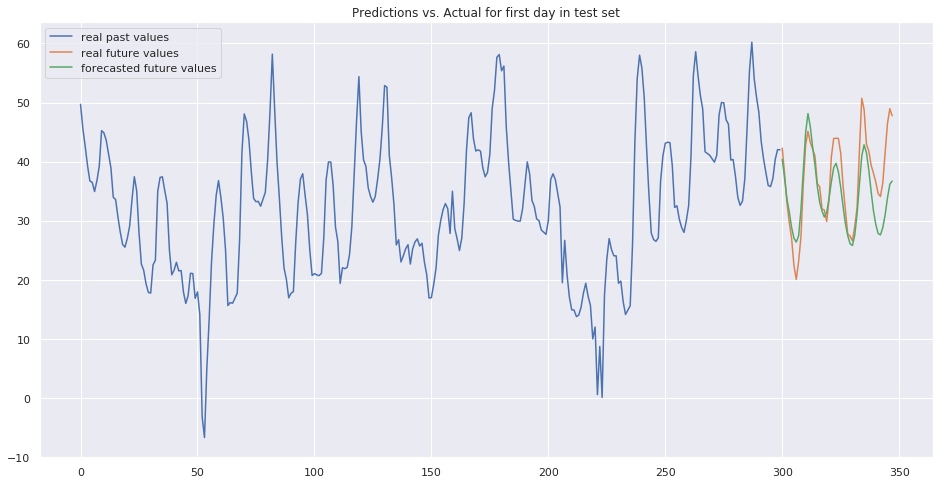

In [18]:

ma, ar = ar_ma(train)

model , preds= train_predict_sarimax(train , (ar,0,ma), (0,0,0,0))
print('MAE :',mean_absolute_error(preds[24:], test[24:48]))
print('RMSE :',np.sqrt(mean_squared_error(preds[24:], test[24:48])))
print('MAPE : ',mean_absolute_percentage_error(test[24:48],preds[24:]))
plot_preds(train[-300:],test[:48],preds)



MAE : 3.0730557573034125
RMSE : 4.1091191441490365
MAPE :  19.169987368262195


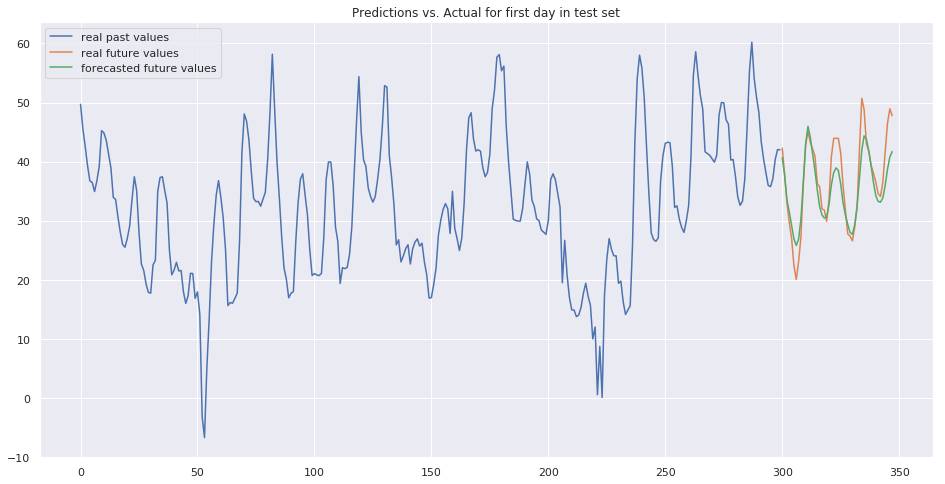

In [19]:
# ma, ar = ar_ma(train)
model , preds= train_predict_sarimax(train , (ar,1,ma), (0,0,0,0))
print('MAE :',mean_absolute_error(preds[24:], test[24:48]))
print('RMSE :',np.sqrt(mean_squared_error(preds[24:], test[24:48])))
print('MAPE : ',mean_absolute_percentage_error(test[24:48],preds[24:]))
plot_preds(train[-300:],test[:48],preds)

MAE : 2.772563221758425
RMSE : 3.3451607269945427
MAPE :  18.80477980540201


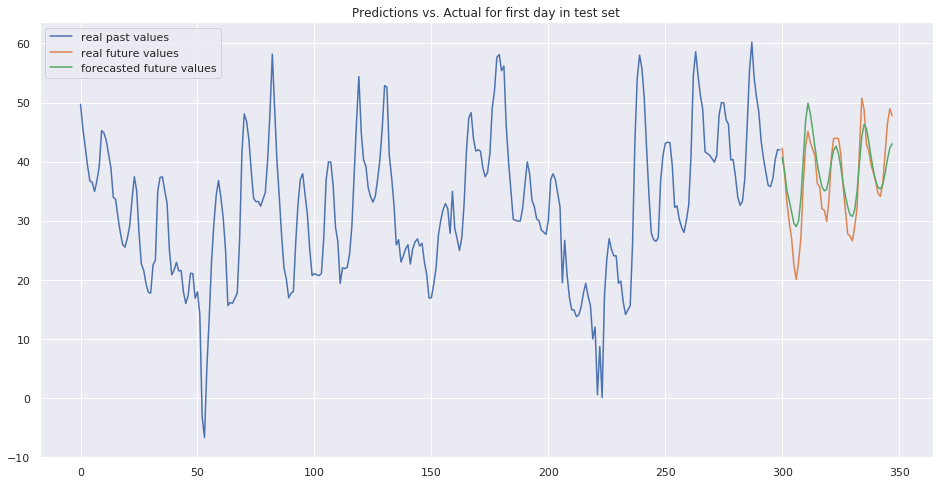

In [20]:
model , preds= train_predict_sarimax(train , (ar,2,ma), (0,0,0,0))
print('MAE :',mean_absolute_error(preds[24:], test[24:48]))
print('RMSE :',np.sqrt(mean_squared_error(preds[24:], test[24:48])))
print('MAPE : ',mean_absolute_percentage_error(test[24:48],preds[24:]))
plot_preds(train[-300:],test[:48],preds)

MAE : 15.273287634448707
RMSE : 16.243650036797128
MAPE :  38.17659417256564


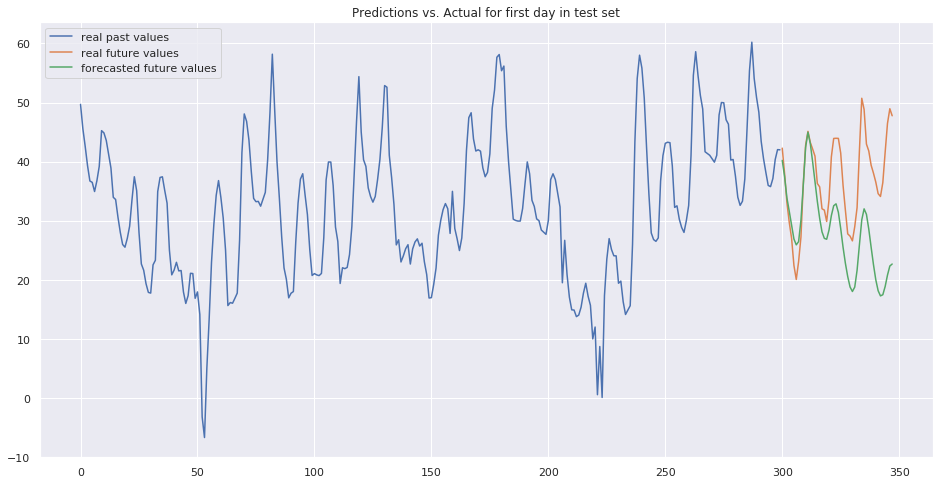

In [21]:
model , preds= train_predict_sarimax(train , (ar,3,ma), (0,0,0,0))
print('MAE :',mean_absolute_error(preds[24:], test[24:48]))
print('RMSE :',np.sqrt(mean_squared_error(preds[24:], test[24:48])))
print('MAPE : ',mean_absolute_percentage_error(test[24:48],preds[24:]))
plot_preds(train[-300:],test[:48],preds)

$\rightarrow$ Arima(ar,2,ma) gave better results 

## SARIMA(p,d,q)(P,D,Q)
Here we introduce seasonality parameters :
Sarima is more complex and needs too much time for running. For this reason, i couldn't try different parameters.
Baseline : 
- P: Seasonal autoregressive order.(1 to take the autoregressive features from the previous season)
- D: Seasonal difference order.(1 to consider the differncing between consecutive seasons)
- Q: Seasonal moving average order.(0 to consider that consecutive seasonal forecasts are independent)


MAE : 3.733009693773411
RMSE : 4.623798787332872
MAPE :  23.27001631030667


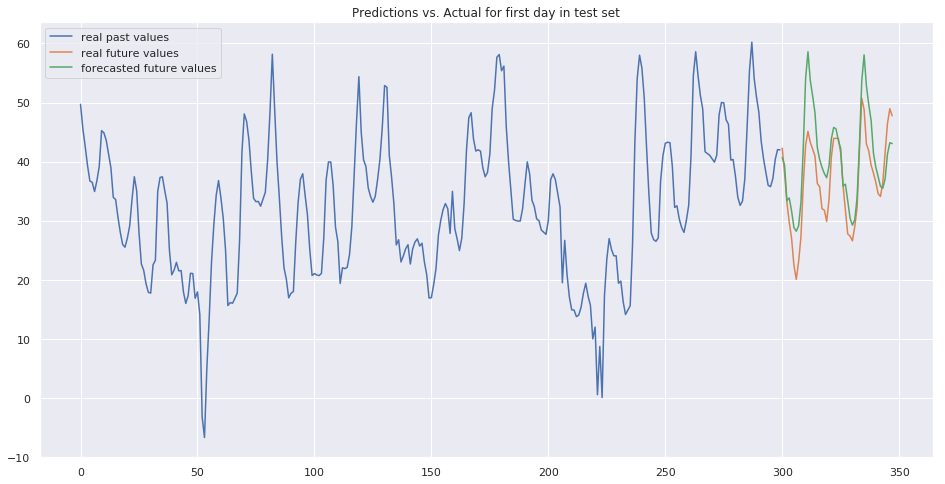

In [17]:
s_ma,s_ar = ar_ma (train, nlags= 24)
ma, ar = ar_ma(train)
model , preds= train_predict_sarimax(train , (ar,2,ma), (1,1,0,24))
print('MAE :',mean_absolute_error(preds[24:], test[24:48]))
print('RMSE :',np.sqrt(mean_squared_error(preds[24:], test[24:48])))
print('MAPE : ',mean_absolute_percentage_error(test[24:48],preds[24:]))
plot_preds(train[-300:],test[:48],preds)

In [0]:
s_ma,s_ar = ar_ma (train, nlags= 168)
model , preds= train_predict_sarimax(train , (ar,2,ma), (s_ar,0,s_ma,168))
print('MAE :',mean_absolute_error(preds[24:], test[24:48]))
print('RMSE :',np.sqrt(mean_squared_error(preds[24:], test[24:48])))
print('MAPE : ',mean_absolute_percentage_error(test[24:48],preds[24:]))
plot_preds(train[-300:],test[:48],preds)

In [0]:
s_ma,s_ar = ar_ma (train, nlags= 168*4)
model , preds= train_predict_sarimax(train , (ar,2,ma), (s_ar,0,s_ma,168*4))
print('MAE :',mean_absolute_error(preds[24:], test[24:48]))
print('RMSE :',np.sqrt(mean_squared_error(preds[24:], test[24:48])))
print('MAPE : ',mean_absolute_percentage_error(test[24:48],preds[24:]))
plot_preds(train[-300:],test[:48],preds)

$\rightarrow$ Owing to time constraints, i didn't succed to test other parameters for Sarima as it takes so much time for running even with Googlecolab. 

### FB Prophet model : 

In [0]:
from fbprophet import Prophet

In [0]:
def train_predict_prophet(df, start, end, h,**kwargs): 
    if 'multiplicative' in kwargs: 
        mode = 'multiplicative'
    else :
        mode = 'additive'
    data=df[start:end]
    data = pd.DataFrame({'ds':data.index.values, 'y':data.Value.values})
    train , test = data.iloc[:-h], data.iloc[-h:]
    m = Prophet(seasonality_mode=mode)
    m.fit(train)
    future = test[['ds']]
    forecast = m.predict(future)
    
    plot_preds(train['y'].values[-200:],test['y'].values,forecast['yhat'].values)
    print('MAE :',mean_absolute_error(test['y'].values[-24:],forecast['yhat'].values[-24:]))
    
    print('RMSE : ', np.sqrt(mean_squared_error(test['y'].values[-24:],forecast['yhat'].values[-24:])))
    print('MAPE : ',mean_absolute_percentage_error(test['y'].values[-24:],forecast['yhat'].values[-24:]))

    return forecast
    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


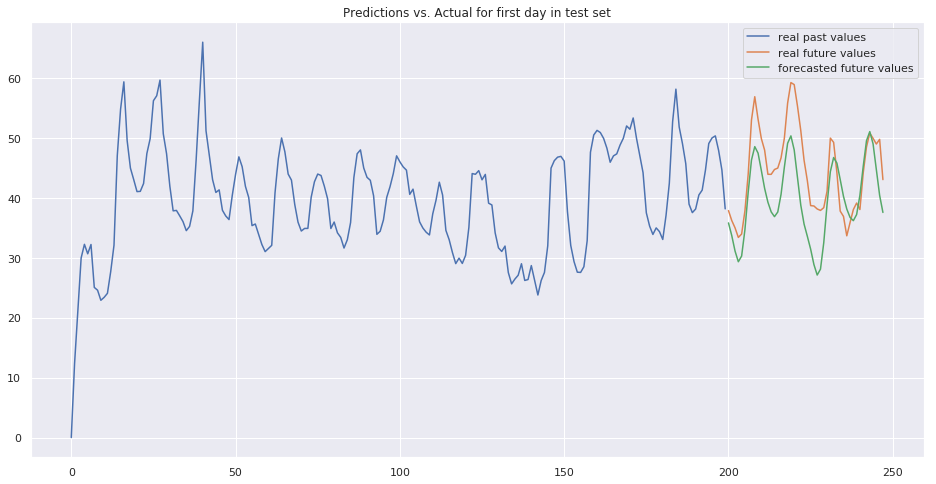

MAE : 4.475578722015182
RMSE :  5.562026118920262
MAPE :  10.953162827802839


In [39]:
preds = train_predict_prophet(Dataframe, '2018-01', '2018-05', 48)

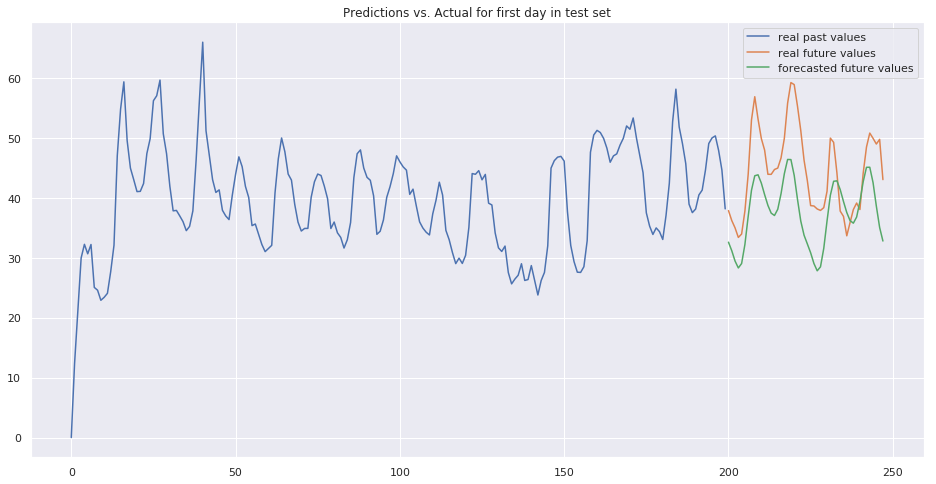

MAE : 6.097340390177076
RMSE :  7.194819564201351
MAPE :  14.232664498668932


In [40]:
preds = train_predict_prophet(Dataframe, '2016-01', '2018-05', 48, multiplicative = True)

$\rightarrow$ Prophet with additive mode gave better results for the first day

## Use Machine learning algorithms : 
### XGBOOST

In [0]:
### xgboost : 

def create_dataset(df, start, end, nlags, h, scale = False ): 
    
    data=df[start:end]
    ## scale data for SVR
    if scale :
        from sklearn.preprocessing import MinMaxScaler
        scaler=MinMaxScaler()
        data['Value']= scaler.fit_transform(data['Value'].values.reshape(-1,1))
    data['ds']= pd.to_datetime(data.index.values)
    data.index=np.arange(len(data))
### Add features to the data 

#     data['H']= data['ds'].dt.hour
#     data['D']= data['ds'].dt.day
#     data['M']= data['ds'].dt.month
#     data['Y']= data['ds'].dt.year
#     data['ts']= data['ds'].values.astype(np.int64) // 10 ** 9

### Add lags features to the datas
    for l in range(25, nlags+25):
        data['l_{}'.format(l)] = data['Value'].shift(l)
   
    data.dropna(axis=0, inplace=True)
    data.drop(['ds'], axis=1, inplace=True)
    train = data[:-h]
    test=data[-h:]
    return train , test
            

In [0]:
# use more historical data 
xy_train, xy_test = create_dataset(Dataframe, '2016-01', '2018-05', 48, 48)

In [0]:
xgb = XGBRegressor(n_estimators=1000,max_depth=5)
xgb.fit(xy_train.drop(['Value'], axis=1), xy_train.Value)
xgb_preds= xgb.predict(xy_test.drop(['Value'], axis=1))

[02:58:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


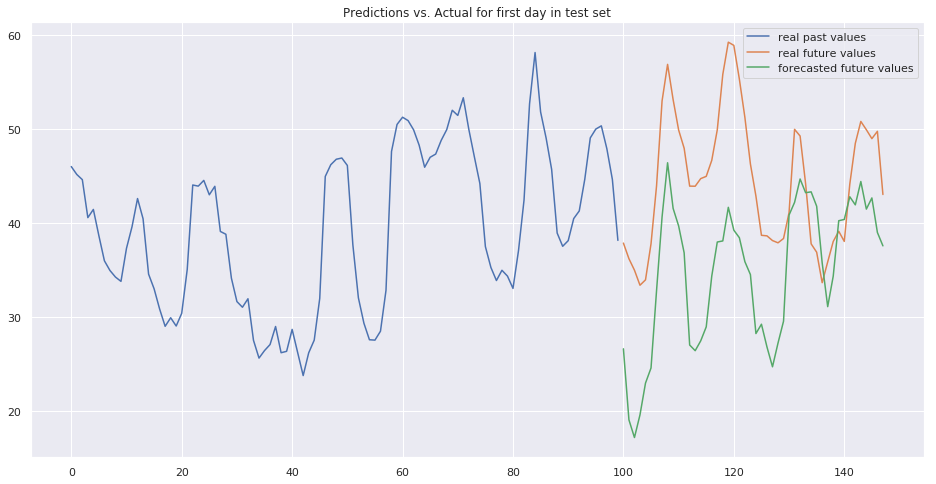

RMSE :  7.472906245526944
MAPE :  15.090571849876849


In [0]:
plot_preds(xy_train[-100:].Value.values,xy_test[:48].Value.values,xgb_preds)
print('MAE :',mean_absolute_error(xy_test[24:].Value.values,xgb_preds[24:]))
print('RMSE : ', np.sqrt(mean_squared_error(xy_test[24:].Value.values,xgb_preds[24:])))
print('MAPE : ',mean_absolute_percentage_error(xy_test[24:].Value.values,xgb_preds[24:]))

### SVR : 

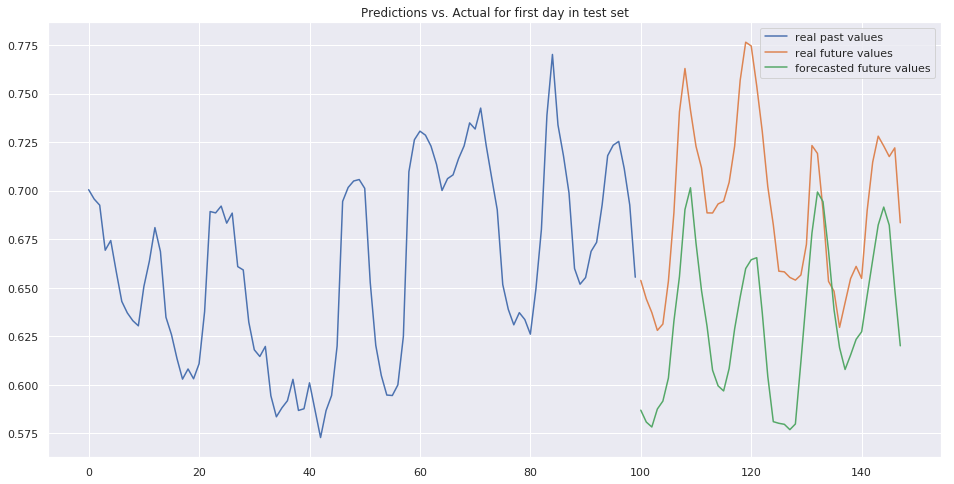

MAPE :  6.560327364691494


In [0]:
from sklearn.svm import SVR
xy_train, xy_test = create_dataset(Dataframe, '2018-01', '2018-05', 48, 48, scale = True)
svr = SVR(kernel='linear')
svr.fit(xy_train.drop(['Value'], axis=1), xy_train.Value)
svr_preds= svr.predict(xy_test.drop(['Value'], axis=1))
plot_preds(xy_train[-100:].Value.values,xy_test[:48].Value.values,svr_preds)
print('MAE :',mean_absolute_error(xy_test[24:].Value.values,svr_preds[24:]))
print('MAPE : ',mean_absolute_percentage_error(xy_test[24:].Value.values,svr_preds[24:]))

### NEURAL NETWORK : 
Data transformations : 
We will create lags by shifting the data so that for each observation we will find the DA_price at a given hour as well as the prices of last 192 hours prior to that hour. But since we assumed that we have no access to the prices of the day before, we will remove the corresponding 24 hours. $\rightarrow$ we will add a total number of 168 features.
As output, we will have a vector of length 24, one entry for each hour of the prediction day.

In [0]:
def create_data_nn (df, nlags):
    ## data lagging in order to see last observations
    data=df.copy()
    for l in range(25, nlags+1):
        data['l_{}'.format(l)] = data['Value'].shift(l)
    data.dropna(inplace=True)
    # create feature and label dataframes
    prelim_features = data.drop('Value', axis=1)
    prelim_labels = pd.DataFrame(data['Value'])

    # format labels to 24 hour output range
    for i in range(0, 24):
        prelim_labels['t_{}'.format(i)] = prelim_labels['Value'].shift(-i)
    prelim_labels.drop('Value', axis=1, inplace=True)
    # apply one-day discretization to the data
    labels = prelim_labels[prelim_labels.index.hour == 0]
    features = prelim_features[prelim_features.index.hour == 0]
    ## create train and test set
    features_train = features[:'2017']
    features_test = features['2018':]
    labels_train = labels[:'2017']

    samples_train = len(features_train)
    samples_test = len(features_test)
    timesteps = 8*24-24

    # convert pandas data frames to numpy ndarrays
    features_train = features_train.values.reshape(samples_train, timesteps, 1)
    features_test = features_test.values.reshape(samples_test, timesteps, 1)
    labels_train = labels_train.values

    return features_train, labels_train,features_test
## keep the most recent for testing ==> data from 2018 


In [0]:
## scale the data and create train test sets : 

scaler = MinMaxScaler()
df= Dataframe.copy()
Test_data=df['2018']## keep the most recent for testing ==> data from 2018 
df = IQR_outliers_detection(df, 'Value', 3)
df['Value'] = scaler.fit_transform(df)
features_train, labels_train,features_test=  create_data_nn (df, 8*24)
X_train, X_valid, y_train, y_valid = train_test_split(features_train, labels_train, test_size=0.25, random_state=7)


In [0]:
### Fit model to training data. Use best performant on validation data to predict for the test set. 


def train_predict_evaluate(model, X_train, X_valid, y_train, y_valid, X_test, y_test, test_index, scaler, 
                           batch_size, epochs, filename='model.hdf5', verbose=0):

    
    # train model, save best keep best performer on validation set
    checkpoint = ModelCheckpoint('./' + filename, save_best_only=True)
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[checkpoint], 
                     verbose=verbose, batch_size=batch_size, epochs=epochs)
    
    # load best model
    best = load_model('./' + filename)

    # predict for test set
    pred = best.predict(X_test)
    
    
    # transform back to original data scale
    pred = scaler.inverse_transform(pred.flatten().reshape(-1, 1))
    ## return results as dataframes
    results = pd.DataFrame({'prediction':pred.flatten(), 'true values':y_test}, index=test_index)
    
    return results, hist

#### Baseline model : 
**One-dimensional convolutional layer, a recurrent layer of Long Short Term Memory (LSTM) cells and a densely connected layer. The dense layer serves as the output layer. Its size is fixed to 24 cells, one for each hour of the day to predict prices for.**

In [24]:
## Baseline model : 
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(64, kernel_size=24, strides=24, padding='valid')(input_layer)
x = LSTM(32, recurrent_activation='relu')(x)
output_layer = Dense(24)(x)
model = Model(inputs=[input_layer], outputs=[output_layer])
model.compile(loss='mse', optimizer='Nadam')
model.summary()





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 168, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 64)             1600      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                792       
Total params: 14,808
Trainable params: 14,808
Non-trainable params: 0
_________________________________________________________________


In [0]:
# train the model and calculate the performance on the test set
results, hist = train_predict_evaluate(model, X_train, X_valid, y_train, y_valid, features_test,
                                       Test_data.as_matrix().flatten(), Test_data.index, scaler, 32, 200, 
                                       'model.hdf5', verbose=1)

In [28]:
print('MAE: ', mean_absolute_error(y_pred=results['prediction'], y_true=results['true values']))
print('RMSE: ', np.sqrt(mean_squared_error(y_pred=results['prediction'], y_true=results['true values'])))


MAE:  10.115629177356663
RMSE:  13.814705542973098


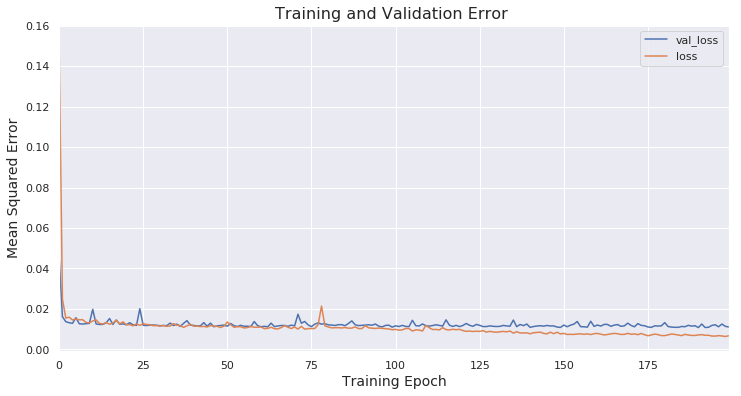

In [27]:
f, ax = plt.subplots()
pd.DataFrame(hist.history).plot(figsize=(12, 6), ax=ax)
ax.set_title('Training and Validation Error ', fontsize=16)
ax.set_ylabel('Mean Squared Error', fontsize=14)
ax.set_xlabel('Training Epoch', fontsize=14);

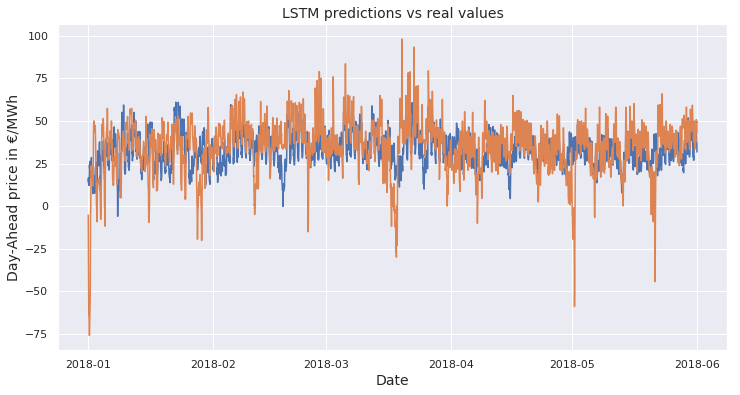

In [31]:
f, ax = plt.subplots(figsize=(12, 6))
plt.plot(results.index, results.prediction)
plt.plot(results.index, results['true values'])
ax.set_ylabel('Day-Ahead price in €/MWh', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('LSTM predictions vs real values', fontsize=14);

In [0]:
### try different parameters : 
def create_model(nodes):
    
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = Conv1D(nodes[0], kernel_size=24, strides=24, padding='valid')(input_layer)
    x = LSTM(nodes[1], recurrent_activation='relu')(x)
    output_layer = Dense(24)(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [0]:
models = []
models.append(create_model([32, 32]))
models.append(create_model([64, 16]))
models.append(create_model([128, 32]))
models.append(create_model([64, 64]))



In [35]:
# train all archtitectures and evaluate performance on the test set
for i, model in enumerate(models):

    results, hist = train_predict_evaluate(model, X_train, X_valid, y_train, y_valid, features_test,
                                           Test_data.as_matrix().flatten(), Test_data.index, scaler, 32, 200, 
                                           'model_.hdf5', verbose=0)
    
    mae = mean_absolute_error(y_pred=results['prediction'], y_true=results['true values'])
    rmse = np.sqrt(mean_squared_error(y_pred=results['prediction'], y_true=results['true values']))
    print('MAE of model {}: '.format(i), mae)
    print('RMSE of model {}: '.format(i), rmse)

MAE of model 0:  9.100272217825811
RMSE of model 0:  12.826601508845826
MAE of model 1:  9.316415249977679
RMSE of model 1:  12.87558905028587
MAE of model 2:  9.553464579296032
RMSE of model 2:  13.565421877345555
MAE of model 3:  9.464997562283186
RMSE of model 3:  12.899962023706331


### Seasonal naive (Benchmark) 
A similar method is useful for highly seasonal data. In this case, we set each forecast to be equal to the last observed value from the same season of the year (e.g., in our case we will take values from d-2 , the same day of the previous week, the average price of the 2 previous weeks and the average price of the 4 previous weeks ).

In [36]:
benchmark_results = pd.DataFrame(index=Test_data.index)

benchmark_results['d-2'] = Dataframe.shift(48)['2018']
benchmark_results['last_week'] = Dataframe.shift(24*7)['2018']
benchmark_results['2_week_average'] = pd.concat([Dataframe.shift(24 * w) for w in range(1, 3)], axis=1).mean(axis=1)['2018']
benchmark_results['4_week_average'] = pd.concat([Dataframe.shift(24 * w) for w in range(1, 5)], axis=1).mean(axis=1)['2018']
# calculate mean absolute errors for benchmark models
for col in benchmark_results.columns:
    pred = benchmark_results[col].values
    true = Test_data.Value.values
    print('MAE of {} benchmark model: '.format(col), mean_absolute_error(y_pred=pred, y_true=true))
    print('RMSE of {} benchmark model: '.format(col), np.sqrt(mean_squared_error(y_pred=pred, y_true=true)))

MAE of d-2 benchmark model:  13.16067880794702
RMSE of d-2 benchmark model:  18.378601537691495
MAE of last_week benchmark model:  12.220030353200881
RMSE of last_week benchmark model:  17.687755903811073
MAE of 2_week_average benchmark model:  10.804795805739515
RMSE of 2_week_average benchmark model:  15.296361898648877
MAE of 4_week_average benchmark model:  10.589357753863135
RMSE of 4_week_average benchmark model:  14.810270888509967


### Improvement points : 
- More data exploration for more relevant business insights. 
- Use other data types( e.g: grid weather data, electricity demand,.. ) that may be correlated with DA prices and then  improve the results .
- Perform grid search to fine tune models' hyperparameters. 